# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




#  Import Required Packages

# Truncated SVD

<ol>
    <li><strong>Apply Truncated-SVD on only this feature set:</strong>
        <ul>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
    <br>
    <li><strong>Procedure:</strong>
        <ul>
    <li>Take top 2000 or 3000 features from tf-idf vectorizers using idf_ score.</li>
    <li>You need to calculate the co-occurrence matrix with the selected features (Note: X.X^T
doesn’t give the co-occurrence matrix, it returns the covariance matrix, check these
        bolgs <a href='https://medium.com/data-science-group-iitr/word-embedding-2d05d270b285'>blog-1,</a> <a href='https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/'>blog-2 </a>for more information)</li>
            <li>You should choose the n_components in truncated svd, with maximum explained
variance. Please search on how to choose that and implement them. (hint: plot of
cumulative explained variance ratio)</li>
            <li>After you are done with the truncated svd, you can apply K-Means clustering and choose
the best number of clusters based on elbow method.</li>
            <li> Print out wordclouds for each cluster, similar to that in previous assignment. </li>
            <li>You need to write a function that takes a word and returns the most similar words using
cosine similarity between the vectors(vector: a row in the matrix after truncatedSVD)</li>
        </ul>
    </li>
    <br>
    
</ol>

## Truncated-SVD

# Import Required Packages

In [1]:
import os
from datetime import datetime
import pandas as pd
import numpy as np

# visualization package
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# data base related package
import sqlite3

# data prerocessing related
from sklearn.preprocessing import StandardScaler

# package for text vectorization (TF-IDF)
from sklearn.feature_extraction.text import TfidfVectorizer 

# truncated SVD for decomposition of co-occurence matrix
from sklearn.decomposition import TruncatedSVD

# package for clustering
from sklearn.cluster import KMeans
# package for evaluating cluster
from sklearn.metrics import silhouette_score

# package for computing cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

# visualization related packages
from wordcloud import WordCloud
from prettytable import PrettyTable

# import model saving, loading related package
import pickle

# UTIL functions

## Fetching top words related functions

In [2]:
def fetch_from_DB(db_path):
    """
    This function fetch required data from the data base given its path
    """
    
    # create a connection object for connecting to DB
    con = sqlite3.connect(db_path)
    
    # fetch required data from DB
    review_txt_df = pd.read_sql_query('SELECT Id, CleanedText, Label from Reviews', con)
    
    # close the existing connection
    con.close()
    
    return review_txt_df

In [3]:
def sample_data_points(final_df):

    # consider first 237800 points for sampling.
    # within 237800 points we have 35000 - ve samples and others are +ve, from this set we
    # can take a sample of 35000 +ve, so we will have a balanced data set having 35K +ve, 35K -ve
    # points which is apt for training the model.

    # partiton the data for train, test data set generation
    final_df_train = final_df[0:237800]
    final_df_test = final_df[237800:]

    # partition the data frame to positive and negative
    final_df_positive = final_df_train[final_df_train['Label'] == 1]
    final_df_negative = final_df_train[final_df_train['Label'] == 0]

    # since positive sample is dominating we select 30K samples randomly from the positive partiion &
    #  take whole negative samples
    final_df_positive = final_df_positive.sample(n=35000)

    # form train sample set
    final_train_df = final_df_positive.append(final_df_negative)
    final_train_df = final_train_df.sample(frac=1.0)
    final_train_df = final_train_df.reset_index(drop=True)

    # print the statistics
    print('Final train df statistics:\n', final_train_df['Label'].value_counts())
    
    
    return final_train_df

In [4]:
def get_top_features(rev_df, num_features):
    """
    This function takes a review data frame as input and returns the top num_features words
    based on idf score.
    """
    
    # create a tf-idf vectorizer
    tf_vectorizer = TfidfVectorizer(min_df=0.005, max_df=0.95)
    
    # fit on the data to get the features
    tf_vectorizer.fit(rev_df['CleanedText'])
    
    # form feature, idf tuples
    feat_idf_list = list(zip(tf_vectorizer.get_feature_names(), tf_vectorizer.idf_))
    
    # select top num_features features using idf score
    feat_idf_list = sorted(feat_idf_list, reverse=True, key=lambda x: x[1])
    feat_idf_list = feat_idf_list[0:num_features]
    top_features = [item[0] for item in feat_idf_list]
    
    return top_features

In [5]:
def get_only_top_word_reviews(rev_df, top_features):
    """
    This function removes all non top words from a review data set and returns the
    dataset having only the top words
    """

    top_word_txt_list = list()

    # process each and every review
    for text_str in rev_df['CleanedText']:
        
        # remove non top words from the list
        top_words = list(filter(lambda x : x in top_features, text_str.split()))
        top_word_txt = ' '.join(top_words)
        
        # update top words list
        top_word_txt_list.append(top_word_txt)
        
    rev_df['CleanedText'] = top_word_txt_list
    
    # remove all entries where the review length is less than two
    rev_df = rev_df[rev_df['CleanedText'].apply(lambda x: len(x) > 1)]

    return rev_df

## Co-Occurence Computation

In [6]:
def compute_cooccurence_vector(vocab_list, window_size, rev_df):
    """
    This function will compute the co-occurence matrix given a document,
    list of voacabulary and a window size.
    """
    
    # get vocabulary size
    vocab_size = len(vocab_list)
    
    # initialize the co occurence matrix
    co_occurence_matrix = np.zeros([vocab_size, vocab_size], dtype=int)
    co_occurence_matrix = pd.DataFrame(co_occurence_matrix, columns=vocab_list)
    co_occurence_matrix.index = vocab_list
    
    # process each review one by one
    for text in rev_df['CleanedText']:
    
        # get document as list of words
        doc_word_list = text.split()
        doc_size = len(doc_word_list)
        
        # do for every word in the text
        for foc_word_loc, focused_word in enumerate(doc_word_list):

            # get preceeding window
            preceeding_window = doc_word_list[max(foc_word_loc - window_size, 0) : foc_word_loc]
            
            # do for all words in the preceeding window
            for pre_word in preceeding_window:
                co_occurence_matrix.loc[focused_word, pre_word] += 1 

            # get succeeding window
            succedding_window = doc_word_list[foc_word_loc + 1 : min(foc_word_loc + window_size + 1, doc_size)]
            
            # do for all words in the succeeding window
            for suc_word in succedding_window:
                co_occurence_matrix.loc[focused_word, suc_word] += 1    
    
    return co_occurence_matrix

## Clustering related functions

In [7]:
def find_best_hyperparameter(config_dict, train_features):
    
    """
    This function helps to find the best hyper parameter for the clustering algorithm.
    All set of hyper param values using which the model to be evaluated can be passed to the
    list hyperparam_list"""
    
    print('='*100)
    
    hyperparam_list = config_dict['hyperparam_list']
    
    hyper_param_score_list = list()
    inertia_score_list = list() # for k-means algorithm

    for hyp_vals in hyperparam_list:

        # Model defined here
        # create an object of clustering algorithm
        clustering_model = KMeans(n_clusters=hyp_vals, init='k-means++', n_init=10)

        # fit on data
        clustering_model.fit(train_features)
        # get the inertia value as score
        inertia_val = clustering_model.inertia_

        # get the silhouytte score for this clustering
        if len(set(clustering_model.labels_)) == 1:
            sil_score = -1
        else:    
            sil_score = silhouette_score(train_features, clustering_model.labels_)

        # append hyper param scores
        inertia_score_list.append((hyp_vals, inertia_val,))
        hyper_param_score_list.append((hyp_vals, sil_score,))
     
    
    # plot k versus inertia
    inertia_values_list = [item[1] for item in inertia_score_list] 
    plt.plot(hyperparam_list, inertia_values_list)
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia Value')
    plt.title('Elbow Method')
    plt.show()
                
    return hyper_param_score_list

In [8]:
def get_cluster_id(config_dict, score_list, train_features):
    """
    This function returns a data frame having data point ID and 
    the corresponding cluster ID.
    """
    
    # get the best hyperparams from the list
    hyp_vals, hyp_score = max(score_list, key=lambda x: x[1])

    # get configuration values
    hyperparam_list = config_dict['hyperparam_list']
    
    # Model defined here
    print('Best hyper param selected n_clusters : %d '%hyp_vals)
    print('Best silhoutte score for this hyper parameter : %f'%hyp_score)
    clustering_model = KMeans(n_clusters=hyp_vals, init='k-means++', n_init=10)
    
    # fit on the data
    clustering_model.fit(train_features)
    
    # get the labels for each data point (i.e cluster id)
    assigned_cluseter_ids = clustering_model.labels_
    
    # create a data frame with review ID and its predicted cluster
    pred_df = pd.DataFrame({'Id': train_features.index, 
                            'Cluster' : assigned_cluseter_ids}, 
                           index=range(train_features.shape[0]))
    
    try:
        sil_score = silhouette_score(train_features, clustering_model.labels_)
    except:
        sil_score = -1.0
    
    # get cluster related information
    cluster_info = str(dict(pred_df['Cluster'].value_counts()))
    
    table_entry = (hyp_vals, '{0:.4f}'.format(sil_score), cluster_info,)
    
    return (table_entry, pred_df,)
    

In [9]:
def get_cluster_wordcloud(pred_cluster_df):
    """
    This function shows the word cloud for each cluster given the predicted cluster information.
    """
    
    # create a word cloud template for each cluster word cloud
    wc = WordCloud(background_color='white', width=800, height=800)
    
    # do word cloud for each cluster
    for gid, gdf in pred_cluster_df.groupby(['Cluster']):
        
        print('='*100)
        
        # initialize a text for this cluster, this will hold all the words that belong to this cluster
        cluster_words = gdf['Id'].tolist()
        cluster_words = ' '.join(cluster_words)
            
        # generate word cloud for this cluster
        wc_output = wc.generate(cluster_words)
        
        plt.figure(figsize=(8,8))
        plt.imshow(wc_output)
        plt.axis('off')
        plt.title('Word Cloud for Cluster ID: %d'%(gid,))
        plt.tight_layout(pad=0.0)
        plt.show()
        
        print('='*100)

## Find most similar word 

In [10]:
def get_most_similar_word(cooccurence_reduced_matrix, input_word, num_words):
    """
    This function finds the most similar word to the given word using cosine similarity metric
    and returns the most similar word along with its similarity value
    """
    
    # get the vector representation of the given word
    try:
        input_vector = cooccurence_reduced_matrix.loc[input_word, :]
    except:
        print('The input word is not present in the vocabulary')
        return
    
    # compute distance to every word
    all_distances = list()
    
    temp_matrix = cooccurence_reduced_matrix.drop([input_word], axis=0)
    
    # get distance to every object in temp_matrix
    dist_values = cosine_similarity(temp_matrix, [input_vector])
    temp_matrix['Similarity'] = dist_values
    
    # get most similar words and its similarity
    temp_matrix = temp_matrix.sort_values(['Similarity'], ascending=False)
    
    # get top similar words
    temp_matrix = temp_matrix.iloc[0:num_words,:]
    temp_matrix['Similar_Words'] = temp_matrix.index.tolist()
    temp_matrix = temp_matrix[['Similar_Words', 'Similarity']]
    temp_matrix = temp_matrix.reset_index(drop=True)
        
    return temp_matrix

### [A] Taking top features from TFIDF,<font color='red'> SET 2</font>

In [11]:
# read database and get the required columns
db_path = '/home/amd_3/AAIC/ASM_REPO/Processed_data/AMZN_FOOD_REVIW/final.sqlite'
rev_df = fetch_from_DB(db_path)

# sample data points from the database
rev_df = sample_data_points(rev_df)
print('Sample data frame head:\n', rev_df.head())

# select top features from the tf-idf vectorizer
#rev_df = rev_df.iloc[0:3000]
num_features = 3000
top_features = get_top_features(rev_df, num_features)

Final train df statistics:
 1    35000
0    34997
Name: Label, dtype: int64
Sample data frame head:
        Id                                        CleanedText  Label
0    4301  great idea fall short bisquick gluten free sti...      0
1    7951  glad nail deco becom adult deco not littl girl...      1
2  515646  brought store absolut horriabl make mine everi...      0
3  537093  ami kitchen came exist ami born parent deepli ...      1
4   13108  true coffe lover favorit beverag morn night en...      0


### [B] Calulation of Co-occurrence matrix

In [12]:
vocab_size = len(top_features)
# set window size for co-occurence matrix computation
window_size = 5
rev_df = get_only_top_word_reviews(rev_df, top_features)
rev_df.head()

,Id,CleanedText,Label
0,4301,great idea fall short gluten free still use ba...,0
1,7951,glad becom adult not littl not sure start adul...,1
2,515646,brought store absolut make mine everi year dec...,0
3,537093,kitchen came produc conveni prepar food tast h...,1
4,13108,true coffe lover favorit beverag morn night en...,0


In [13]:
# get co-occurence matrix by processing each document
co_occ_matrix = compute_cooccurence_vector(top_features, window_size, rev_df)
    
co_occ_matrix.head()

,fell,flower,latt,scratch,distinct,crush,peach,purpos,retail,tabl,...,tri,flavor,veri,would,good,one,product,like,tast,not
fell,2,0,0,0,0,0,0,0,0,1,...,54,38,15,10,23,44,24,35,34,92
flower,0,118,0,0,0,3,0,1,0,1,...,25,37,53,33,34,52,28,68,42,173
latt,0,0,58,0,0,0,0,0,0,0,...,48,85,35,28,57,45,26,89,91,119
scratch,0,0,0,24,0,0,0,1,0,0,...,45,16,29,63,27,30,27,43,42,133
distinct,0,0,0,0,2,0,1,0,0,1,...,23,193,56,19,33,27,26,60,167,152


In [14]:
co_occ_matrix.max().max()

27180

### [C] Finding optimal value for number of components (n) to be retained.

In [15]:
# column standardize the data
std_scaler = StandardScaler()
std_scaler.fit(co_occ_matrix)
# get standardized co occurance matrix
scaled_cooccurence_matrix = std_scaler.transform(co_occ_matrix)
scaled_cooccurence_matrix.shape

(1083, 1083)

In [16]:
total_dimension = scaled_cooccurence_matrix.shape[1]
# decompose co-occurence matrix using svd
truc_svd = TruncatedSVD(n_components=total_dimension-1 , algorithm='randomized', n_iter=5)
# fit to data
truc_svd.fit(scaled_cooccurence_matrix)

TruncatedSVD(algorithm='randomized', n_components=1082, n_iter=5,
       random_state=None, tol=0.0)

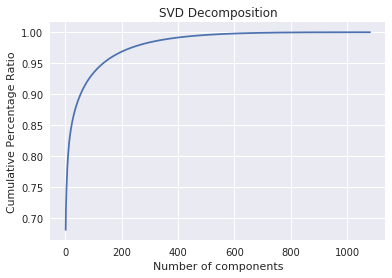

Num dimensions selected by SVD 206
Total variance captured:0.970124


In [17]:
# get explained variance ratio of each component
explained_var_ratios = truc_svd.explained_variance_ratio_
# get cummulative ratio list for selecting the number of components
cumulative_ratios = np.cumsum(explained_var_ratios)

# plot the #components vs captured variance in the data
plt.title('SVD Decomposition')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Percentage Ratio')
plt.plot(range(1, total_dimension), cumulative_ratios)
plt.show()

# set a threshold for stopping selection of components.
svd_thesh = 0.0002
# select the number of components as the first component for which the difference between cummulative ratio is
#  very less (less than svd thresh) compared with the very next component
selected_dim = list(filter(lambda x : x[1] < svd_thesh, enumerate(np.diff(cumulative_ratios))))[0][0]
print('Num dimensions selected by SVD', selected_dim)
print('Total variance captured:%f'%(cumulative_ratios[selected_dim]))

In [18]:
# decompose co-occurence matrix using svd
truc_svd = TruncatedSVD(n_components=selected_dim , algorithm='randomized', n_iter=5)
# fit to data
truc_svd.fit(scaled_cooccurence_matrix)

# reduce the number of dimensions to selected number of components
cooccurence_reduced_matrix = pd.DataFrame(truc_svd.transform(scaled_cooccurence_matrix))
cooccurence_reduced_matrix.shape

(1083, 206)

In [19]:
# add the indices as the Ids
cooccurence_reduced_matrix.index = top_features
cooccurence_reduced_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,196,197,198,199,200,201,202,203,204,205
fell,-11.908971,0.122471,-0.018037,0.747795,-1.347756,-0.237927,0.594576,-0.193457,0.377309,-0.109260,...,0.717007,-0.296199,0.293588,0.295610,0.478797,-0.129801,-0.491642,0.366296,-0.014284,-0.199029
flower,-10.266217,-0.166247,1.287535,0.974437,-1.600630,0.065491,-0.228435,3.329714,0.889990,-0.139201,...,-0.210854,-0.295307,-0.467656,-0.094912,0.605091,0.260850,0.693741,0.578893,-0.343516,-0.503105
latt,-11.496927,1.862264,2.174452,0.730891,-0.528605,1.422207,0.552794,-0.596873,0.200043,-0.330634,...,-0.294603,-0.368374,-0.316942,0.158499,0.085803,-0.010343,-0.026156,-0.316629,-0.295768,0.110796
scratch,-11.768927,0.300640,-0.770596,0.044407,-0.401578,0.386592,0.154818,-0.699544,1.018676,-0.370326,...,0.095685,0.067162,0.099799,-0.055217,-0.316437,-0.157155,-0.084605,-0.026817,-0.239177,-0.248017
distinct,-12.109134,1.681081,0.104261,1.669296,-0.713697,0.167556,0.363266,-0.020534,0.055710,-0.190754,...,-0.021709,0.071632,0.127043,-0.043599,-0.163827,0.158401,0.052291,-0.111211,-0.050749,-0.028124


### [D] Applying k-means clustering

In [20]:
config_dict = {
    'hyperparam_list' : [2, 3, 4, 5, 6] # the list of k values that will be tried
}

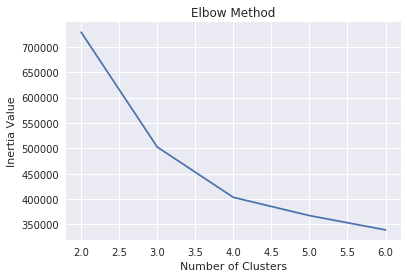

In [21]:
score_list = find_best_hyperparameter(config_dict, cooccurence_reduced_matrix)

In [22]:
table_entry_cluster, pred_df = get_cluster_id(config_dict, score_list, cooccurence_reduced_matrix)
pred_df.head()

Best hyper param selected n_clusters : 2 
Best silhoutte score for this hyper parameter : 0.853924


,Id,Cluster
0,fell,0
1,flower,0
2,latt,0
3,scratch,0
4,distinct,0


In [23]:
score_list

[(2, 0.8539236047313035),
 (3, 0.7646800882184036),
 (4, 0.5858222137271532),
 (5, 0.5586332383022342),
 (6, 0.425517514610418)]

## Observation

%%HTML
<ul>
<li> As the k value increases, the inertia value keeps decresing </li>
<li> From the above plot, the suggested value for k seems to be 4, but silhouette score for k=2 seems good 
     as it has 0.85 (close to 1.0)</li>
<li> silhouette score for k=4 is only 0.58, thus k is selected as 2 </li>
</ul>

### [E] Wordclouds of clusters obtained in the above section

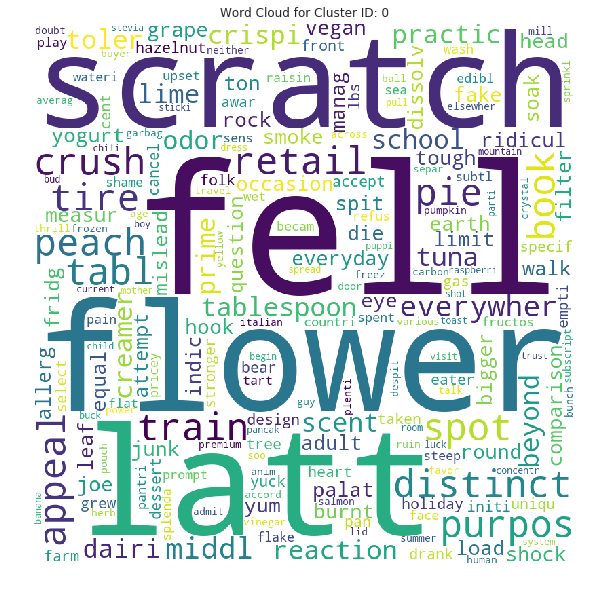

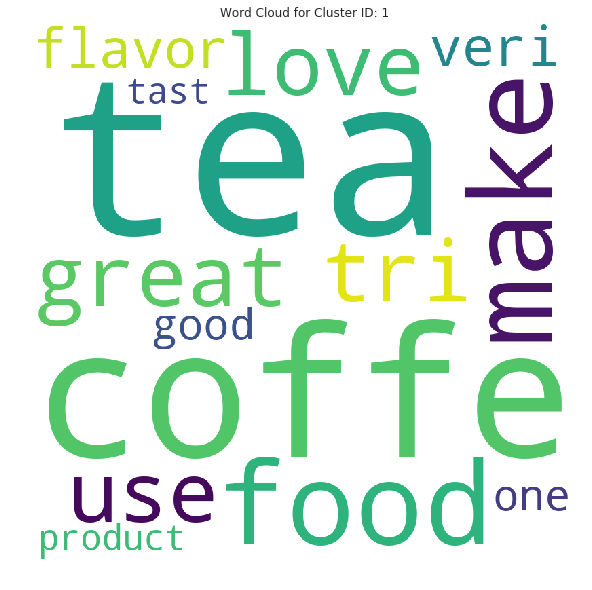

In [24]:
get_cluster_wordcloud(pred_df)

## Observation

%%HTML
<ul>
<li> In cluster ID 1 , we got many words related to beverages like tea, coffee </li>
</ul>

### [F] Function that returns most similar words for a given word.

In [25]:
num_words = 10
most_similar_df = get_most_similar_word(cooccurence_reduced_matrix, 'amazon', num_words)
print('Most similar words of the word amazon :\n', most_similar_df)

Most similar words of the word amazon :
   Similar_Words  Similarity
0         order    0.782391
1       purchas    0.762196
2          item    0.751394
3       product    0.724469
4           buy    0.723087
5         price    0.699992
6           see    0.688144
7          find    0.674775
8          ship    0.657843
9          case    0.656573


In [26]:
num_words = 10
most_similar_df = get_most_similar_word(cooccurence_reduced_matrix, 'coffe', num_words)
print('Most similar words of the word coffe :\n', most_similar_df)

Most similar words of the word coffe :
   Similar_Words  Similarity
0           cup    0.791803
1          brew    0.636657
2        flavor    0.635432
3           one    0.624397
4           not    0.624062
5          tast    0.623791
6           tri    0.618240
7         enjoy    0.616825
8           use    0.615481
9          like    0.614030


## Observations

%%HTML
<ul>
<li> The cluster sizes are imbalanced </li>
<li> The smaller cluster got many similar words like coffe, tea, food etc.</li>
<li> The model is able to identify the co-occurence relation between the words (amazon, order) & (coffe, cup) </li>
<li> Cosine similarity for the above pairs are high </li>
</ul>

# Procedure Summary

%%HTML
<ol>
<li> TF-IDF vectorizer is used to vectorize raw text </li>
<li> Top words are selected based on the idf_score </li>
<li> Co-occurence matrix for the vocabulary set by top words is computed </li>
<li> Truncated SVD is used to reduce the dimenion of the co-occurence matrix (2K to 209). So each
     word in the vocabulary will be represented by 209 dimension vector</li>
<li> K-means clustering is done on top of the reduced co-occurence data. It identified the
     optimal number of clusters as 2 based on silhoutte score </li>
<li> Implemented a function that compute the most similar word of the given word from the vocabulary 
     using cosine similarity metric</li>
</ol>

# Results Summary

## SVD

In [27]:
Pret_table_svd = PrettyTable()
Pret_table_svd.field_names = ['Number of Components', 'Cumulative Explained Variance']
Pret_table_svd.title = 'SVD Results Summary'

In [28]:
# SVD method
Pret_table_svd.add_row([selected_dim, cumulative_ratios[selected_dim]] )
print(Pret_table_svd)

+------------------------------------------------------+
|                 SVD Results Summary                  |
+----------------------+-------------------------------+
| Number of Components | Cumulative Explained Variance |
+----------------------+-------------------------------+
|         206          |       0.9701239110910714      |
+----------------------+-------------------------------+


## Kmeans

In [29]:
Pret_table_kmeans = PrettyTable()
Pret_table_kmeans.field_names = ['Number of Clusters (K)', 'Silhouette Score', 
                                 'Cluster Info (id:size)']
Pret_table_kmeans.title = 'K-means Results Summary'

In [30]:
# K-means clustering
Pret_table_kmeans.add_row(list(table_entry_cluster))
print(Pret_table_kmeans)

+--------------------------------------------------------------------+
|                      K-means Results Summary                       |
+------------------------+------------------+------------------------+
| Number of Clusters (K) | Silhouette Score | Cluster Info (id:size) |
+------------------------+------------------+------------------------+
|           2            |      0.8539      |    {0: 1065, 1: 18}    |
+------------------------+------------------+------------------------+


# Conclusions

%%HTML
<ul>
<li> co-occurence based method helps to identify the semantic relationship between words eg:( tea, coffe),
     (amazon, product) etc. </li>
<li> Truncated SVD method helps to reduce large dimension to lower dimension allowing to retain
     almost all information of the original data. (in this example 97%)
<li> Clustering helps to group the documents based on its similarity. We got some clustes where the
     words are similar in terms of the semantic eg: tea, coffe etc.</li>
<li> Silhouette score is a metric for evaluating cluster quality. This metric considers how well 
     every data points of one cluster are similar (intra-cluster similarity) and how dissimilar it is from 
     the other clusters (inter-cluster distance).</li>
</ul>